# Pivoting of the Survey Data

One possible way to unpivot data:
Treat every survey as a row (hence 63 rows), Each row can be interpreted as the aggregated status of a country.
Rows = 63 (For 63 surveys)
Columns = max(N_surveys_per_country) * max(N_participants_per_survey) * max(N_questions_per_survey) = 3 * 12 * 51 = 1836

Another possible way to unpivot data:
Treat every survey + participant combination as a row (that is 286 rows). Each row can be interpreted as an opinion of a participant in a specific survey about a country.
Rows = 286
Columns = max(N_Questions_per_survey) = 51															

We will choose the second method to unpivot the data

In [1]:
## Import the Required Library
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load and Clean

In [2]:
# Importing the first dataframe with survey info
data_original= pd.read_excel(open('RMR_SurveyData.xlsx', 'rb'), sheet_name='Clean Data')  
data_original.head()

,Topic,Date,Participant_ID,Survey_Question,Answers,Category,Scope
0,Country1,"Monday, 09 September, 2019",6.370313e+17,(q104_14) 4. all of the above [question: pleas...,-,priority risks,outcome
1,Country2,"Thursday, 16 April, 2020",6.372202e+17,(q104_14) 4. all of the above [question: pleas...,-,priority risks,outcome
2,Country3,"Friday, 22 March, 2019",6.368731e+17,(q104_14) 4. all of the above [question: pleas...,-,priority risks,outcome
3,Country4,"Friday, 11 December, 2020",6.374304e+17,(q104_14) 4. all of the above [question: pleas...,-,priority risks,outcome
4,Country5,"Thursday, 17 June, 2021",6.375894e+17,(q104_14) 4. all of the above [question: pleas...,-,priority risks,outcome


In [3]:
# Cleaning the data and creating new features
data_original["Date"] = pd.to_datetime(data_original["Date"]) # Take the date column and convert to pd datetime
data_original["Participant_ID"] = data_original['Participant_ID'].astype(str).str.replace('.','').str.replace('e+17','',regex=False)  #transforming the participants ID to string
data_original["Survey_ID"] = (data_original['Topic'] + data_original["Date"].astype(str)) #creating the unique survey ID comnbinig country name and date
data_original["Question_ID"] = data_original["Survey_Question"].str.lower().str.split(')').apply(lambda x: x[0]).str.replace('(','') # getting te questionID
data_original["Question_ID"] = data_original["Question_ID"].apply(lambda x: 'outcome' if x.startswith("q104") else x)
data_original["Question_Text"] = data_original["Survey_Question"].str.split(')').apply(lambda x: x[1]) # getting the question text
data_original["Question_Text"] = data_original["Question_Text"].str.replace('\d+.', '')

In [4]:
# importing the country ID mapping
df_country_mapping = pd.read_csv('Country_Code_Mapping.csv')
df_country_mapping.head()

,Code,Country
0,Country1,Honduras
1,Country2,Nepal
2,Country3,Guatemala
3,Country4,Madagascar
4,Country5,Kenya


In [5]:
# merge country names with country codes
data_original= data_original.merge(df_country_mapping, how = 'left', left_on = 'Topic', right_on = 'Code').drop(columns = ['Code','Topic']) 

In [6]:
# import 2022 survey information provided by the UN
data_2022 = pd.read_excel('RMR_2022_surveys.xlsx')
data_2022.drop(columns = ['Topic_ID'], inplace = True)

In [7]:
# Cleaning the data and creating new features and perform similar steps performed in the original data
data_2022["Date"] = pd.to_datetime(data_2022["Date"])
data_2022['Participant_ID'] = data_2022['Participant_ID'].astype(str).str.replace('.','').str.replace('e+17','',regex=False)
data_2022['Survey_ID'] = (data_2022['Topic'] + data_2022["Date"].astype(str))
data_2022["Question_ID"] = data_2022["Survey_Question"].str.lower().str.split(')').apply(lambda x: x[0]).str.replace('(','')
data_2022["Question_ID"] = data_2022["Question_ID"].apply(lambda x: 'outcome' if x.startswith("q104") else x)
data_2022["Question_Text"] = data_2022["Survey_Question"].str.split(')').apply(lambda x: x[1])
data_2022["Question_Text"] = data_2022["Question_Text"].str.replace('\d+.', '')
data_2022 = data_2022.rename(columns={'Topic': 'Country'})

In [8]:
data_final = pd.concat([data_original, data_2022], axis=0) # concat both the data
data_final.head()

,Date,Participant_ID,Survey_Question,Answers,Category,Scope,Survey_ID,Question_ID,Question_Text,Country
0,2019-09-09,637031251267128,(q104_14) 4. all of the above [question: pleas...,-,priority risks,outcome,Country12019-09-09,outcome,all of the above [question: please select th...,Honduras
1,2020-04-16,637220194850231,(q104_14) 4. all of the above [question: pleas...,-,priority risks,outcome,Country22020-04-16,outcome,all of the above [question: please select th...,Nepal
2,2019-03-22,636873083569421,(q104_14) 4. all of the above [question: pleas...,-,priority risks,outcome,Country32019-03-22,outcome,all of the above [question: please select th...,Guatemala
3,2020-12-11,637430406987255,(q104_14) 4. all of the above [question: pleas...,-,priority risks,outcome,Country42020-12-11,outcome,all of the above [question: please select th...,Madagascar
4,2021-06-17,63758935170437,(q104_14) 4. all of the above [question: pleas...,-,priority risks,outcome,Country52021-06-17,outcome,all of the above [question: please select th...,Kenya


## Lets Pivot the data 

In [9]:
data_final.sort_values(by='Answers',inplace=True) 
concatOutcomes = data_final.groupby(['Country','Survey_ID','Participant_ID','Question_ID']).Answers.apply(lambda x: '|'.join(x)).reset_index()
concatOutcomes['Answers'] = concatOutcomes.Answers.str.lstrip('-|')

In [10]:
survey_data= concatOutcomes.pivot(index=['Country','Survey_ID','Participant_ID'], columns=['Question_ID'], values=['Answers']).reset_index()
survey_data["Participant_ID"] = 'p'+survey_data["Participant_ID"].astype(str)
survey_data=survey_data.droplevel(0,axis=1)

In [11]:
survey_data.columns=["Country","Survey_ID","Participant_ID",'outcome', 'q109', 'q111', 'q112', 'q114', 'q115', 'q117',
       'q118', 'q120', 'q121', 'q123', 'q124', 'q126', 'q127', 'q129', 'q130',
       'q132', 'q133', 'q135', 'q136', 'q138', 'q139', 'q141', 'q143', 'q145',
       'q147', 'q149', 'q152', 'q154', 'q156', 'q158', 'q160', 'q162', 'q164',
       'q166', 'q168', 'q170', 'q170specified_38', 'q170specified_61',
       'q170specified_62', 'q180', 'q182', 'q183', 'q3', 'q7']

In [12]:
survey_data.head()

,Country,Survey_ID,Participant_ID,outcome,q109,q111,q112,q114,q115,q117,...,q168,q170,q170specified_38,q170specified_61,q170specified_62,q180,q182,q183,q3,q7
0,Albania,Country472019-04-11,p636892769794392,Democratic space|Infrastructure & access to so...,NaN,Moderate,NaN,NaN,NaN,NaN,...,NaN,E6,NaN,NaN,NaN,NaN,NaN,NaN,Yes: Moderate,Moderate
1,Albania,Country472019-04-11,p636893140622797,Democratic space|Justice & rule of law|Politic...,NaN,High,NaN,NaN,NaN,NaN,...,NaN,E1,NaN,NaN,NaN,NaN,NaN,NaN,Yes: Moderate,High
2,Albania,Country472019-04-11,p636893695764397,Democratic space|Justice & rule of law|Social ...,Yes: Minor,Don't know,NaN,NaN,NaN,NaN,...,NaN,E4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,Country472019-04-11,p636893809832032,Justice & rule of law|Political stability|Soci...,Yes: Moderate,NaN,NaN,NaN,NaN,NaN,...,NaN,E12,NaN,NaN,NaN,NaN,NaN,NaN,Yes: Strong,Moderate
4,Albania,Country472019-04-11,p636893895810546,Democratic space|Infrastructure & access to so...,NaN,Moderate,Yes: Minor,NaN,NaN,NaN,...,NaN,E9,NaN,NaN,NaN,NaN,NaN,NaN,Yes: Moderate,Moderate


In [13]:
survey_data.to_csv('survey_data.csv',index=False,encoding = 'utf-8-sig')

# EDA

In [17]:
## Import the Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
## Read the pivotted Data
data_pivoted=pd.read_csv("survey_data.csv")
data_pivoted.head()

,Country,Survey_ID,Participant_ID,outcome,q109,q111,q112,q114,q115,q117,...,q168,q170,q170specified_38,q170specified_61,q170specified_62,q180,q182,q183,q3,q7
0,Albania,Country472019-04-11,p636892769794392,Democratic space|Infrastructure & access to so...,NaN,Moderate,NaN,NaN,NaN,NaN,...,NaN,E6,NaN,NaN,NaN,NaN,NaN,NaN,Yes: Moderate,Moderate
1,Albania,Country472019-04-11,p636893140622797,Democratic space|Justice & rule of law|Politic...,NaN,High,NaN,NaN,NaN,NaN,...,NaN,E1,NaN,NaN,NaN,NaN,NaN,NaN,Yes: Moderate,High
2,Albania,Country472019-04-11,p636893695764397,Democratic space|Justice & rule of law|Social ...,Yes: Minor,Don't know,NaN,NaN,NaN,NaN,...,NaN,E4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,Country472019-04-11,p636893809832032,Justice & rule of law|Political stability|Soci...,Yes: Moderate,NaN,NaN,NaN,NaN,NaN,...,NaN,E12,NaN,NaN,NaN,NaN,NaN,NaN,Yes: Strong,Moderate
4,Albania,Country472019-04-11,p636893895810546,Democratic space|Infrastructure & access to so...,NaN,Moderate,Yes: Minor,NaN,NaN,NaN,...,NaN,E9,NaN,NaN,NaN,NaN,NaN,NaN,Yes: Moderate,Moderate


### Year wise distribution of data

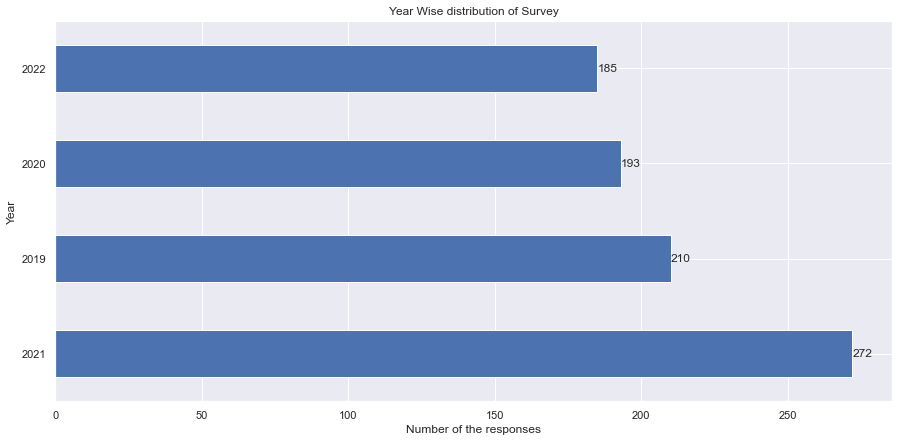

In [3]:
years = pd.to_datetime(data_pivoted.Survey_ID.str.slice(-10)).dt.year.astype(int)
sns.set(rc={'figure.figsize':(15,7)})
ax = years.value_counts().plot(kind = 'barh')
ax.bar_label(ax.containers[0])
ax.set(ylabel='Year', xlabel='Number of the responses')
plt.title("Year Wise distribution of Survey")
plt.show()

### Number of Survey per Country

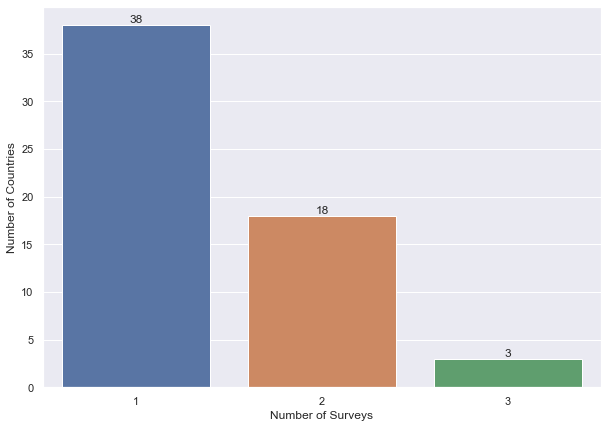

In [4]:
# Extract year from the Survey ID we created
data_pivoted['years_temp'] = pd.to_datetime(data_pivoted.Survey_ID.str.slice(-10,-3)).astype(str)
#Groupby the country and year to get the number of survey conducted in each country
temp = data_pivoted.groupby('Country').years_temp.nunique().reset_index().groupby('years_temp').Country.nunique().reset_index()

sns.set(rc={'figure.figsize':(10,7)})
ax = sns.barplot(data=temp, x="years_temp", y="Country")
ax.bar_label(ax.containers[0])
ax.set(xlabel='Number of Surveys', ylabel='Number of Countries')
plt.show()

del data_pivoted['years_temp']

### Number of unique participants for each country

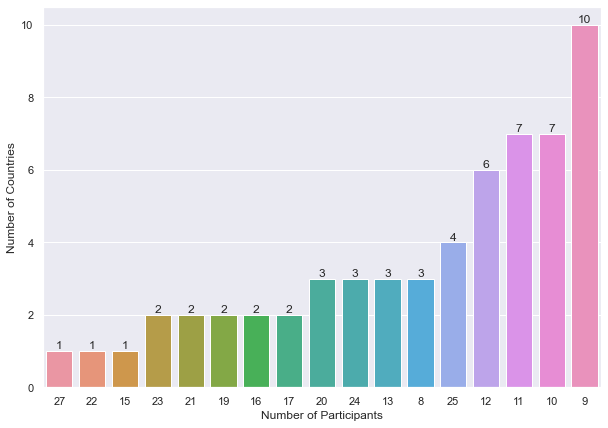

In [5]:
# grouby country and participants 
temp = data_pivoted.groupby('Country').Participant_ID.nunique().reset_index().groupby('Participant_ID').Country.nunique().reset_index()

sns.set(rc={'figure.figsize':(10,7)})
ax = sns.barplot(data=temp, x="Participant_ID", y="Country", order=temp.sort_values('Country').Participant_ID)
ax.bar_label(ax.containers[0])
ax.set(xlabel='Number of Participants', ylabel='Number of Countries')
plt.show()

### Plot of Missing data in whole survey

<AxesSubplot:>

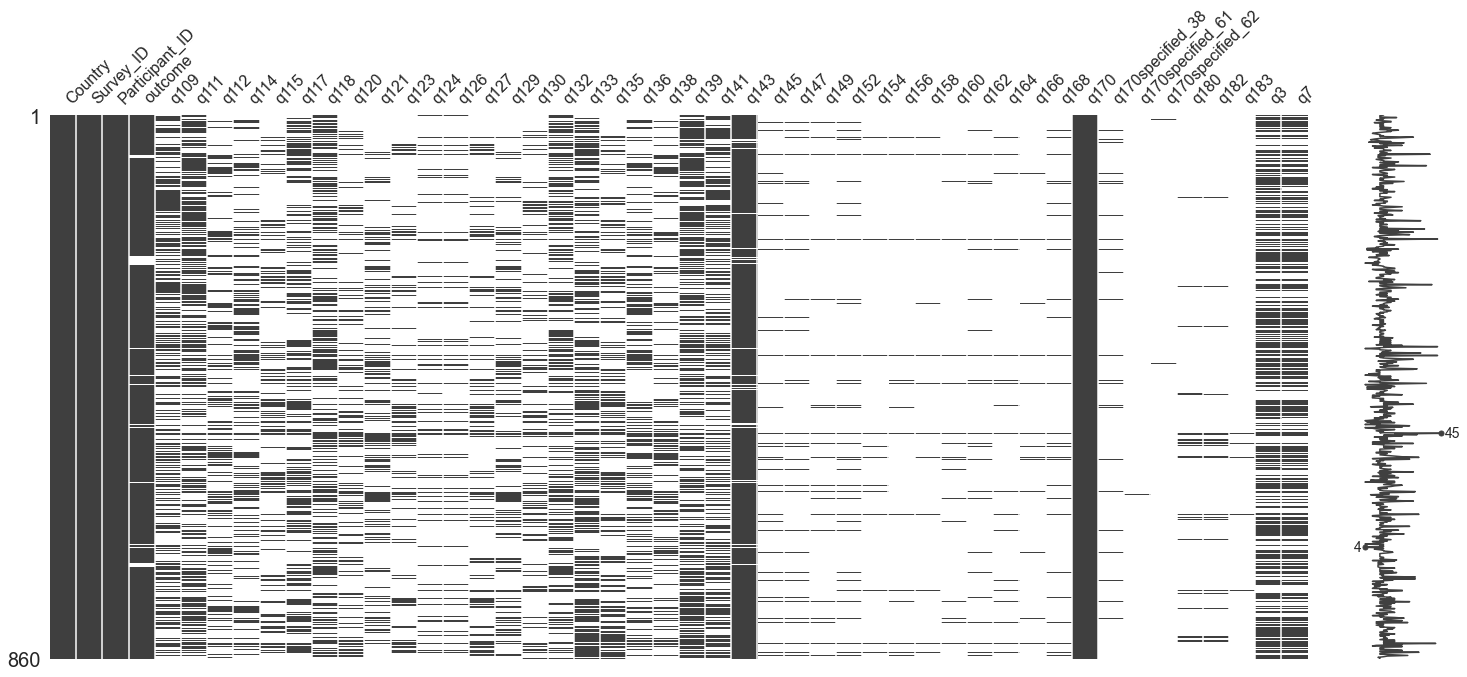

In [6]:
import missingno as msno
msno.matrix(data_pivoted)

#Using the missing number library we plotted the graph, that depicts the missing values in the dataset, there can two reason why the questions 
#have missing value, one is when the participant skipped to answer or  that particular question was not asked to the participants

### Plot the distribution of outcome for the whole data

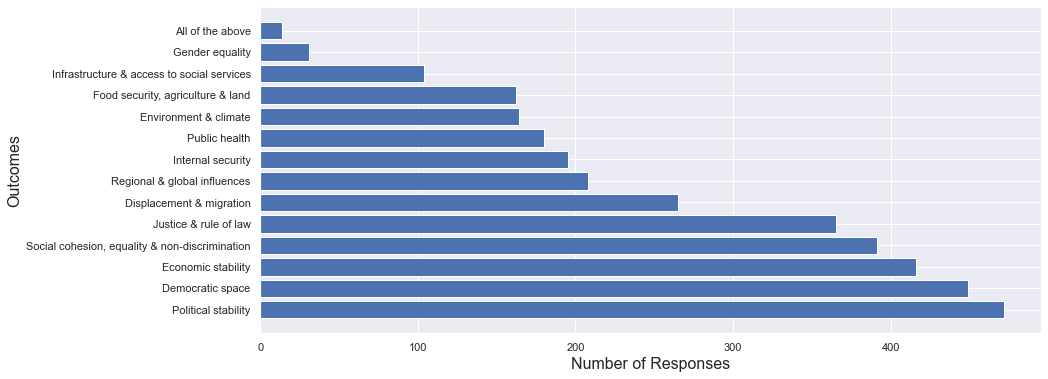

In [7]:
# One hot encoding the data 
dummies = data_pivoted.outcome.str.get_dummies('|') 
#concat the one hot encoded data
data=pd.concat([data_pivoted,dummies],axis=1)


sum_count_dict = {}

#We get the sum of number of times the participant has chose a particular risk factor
for key in data.columns[-14:]:
    sum_count_dict[key] = data[key].sum()

#Sorting the risk factor in the descending order
sum_count_dict = dict(sorted(sum_count_dict.items(), key=lambda item: item[1], reverse=True))

questions, sum_nums = [], []
for key, value in sum_count_dict.items():
    questions.append(key)
    sum_nums.append(value)
    
plt.figure(figsize=(14,6))
plt.barh(questions, sum_nums)
plt.ylabel('Outcomes', fontsize=16)
plt.xlabel('Number of Responses', fontsize=16)
plt.show()

del(data)

In [8]:
questions

['Political stability',
 'Democratic space',
 'Economic stability',
 'Social cohesion, equality & non-discrimination',
 'Justice & rule of law',
 'Displacement & migration',
 'Regional & global influences',
 'Internal security',
 'Public health',
 'Environment & climate',
 'Food security, agriculture & land',
 'Infrastructure & access to social services',
 'Gender equality',
 'All of the above']

### Year wise plot of Number of Responses

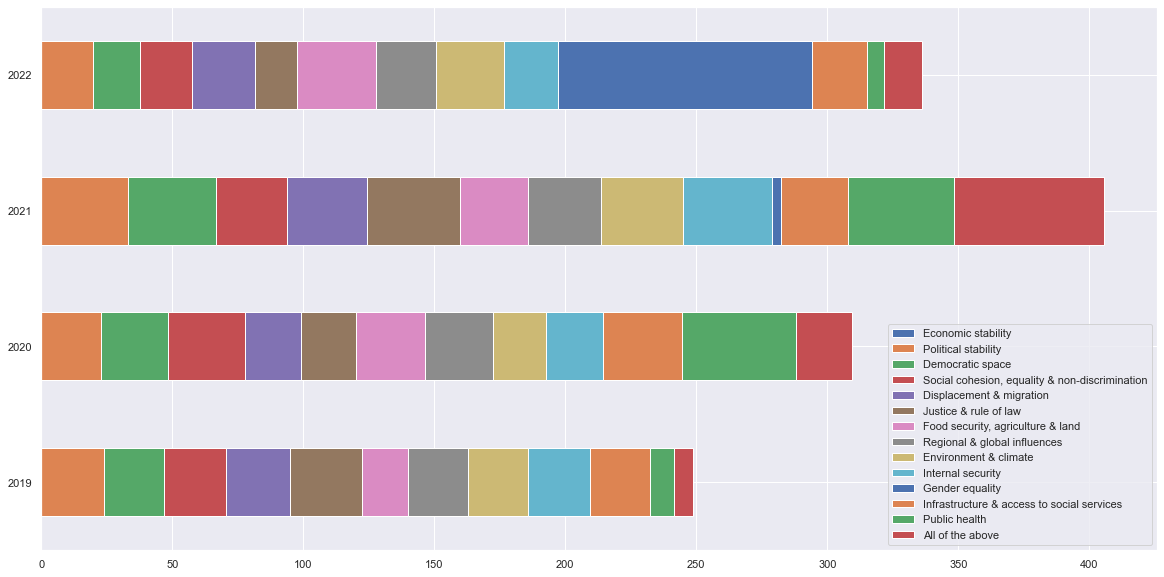

In [9]:
## Split the data into yearwise
# One hot encoding the data 
dummies = data_pivoted.outcome.str.get_dummies('|') 
#concat the one hot encoded data
data=pd.concat([data_pivoted,dummies],axis=1)

data_2019=pd.DataFrame(columns=data.columns)
data_2020=pd.DataFrame(columns=data.columns)
data_2021=pd.DataFrame(columns=data.columns)
data_2022=pd.DataFrame(columns=data.columns)

for i,x in data.iterrows():
    if '2019' in x['Survey_ID']:
        data_2019.loc[len(data_2019.index)] =x
    if '2020' in x['Survey_ID']:
        data_2020.loc[len(data_2020.index)] =x
    if '2021' in x['Survey_ID']:
        data_2021.loc[len(data_2021.index)] =x
    if '2022' in x['Survey_ID']:
        data_2022.loc[len(data_2022.index)] =x

df = pd.DataFrame(columns=['Economic stability',
 'Political stability',
 'Democratic space',
 'Social cohesion, equality & non-discrimination',
 'Displacement & migration',
 'Justice & rule of law',
 'Food security, agriculture & land',
 'Regional & global influences',
 'Environment & climate',
 'Internal security',
 'Gender equality',
 'Infrastructure & access to social services',
 'Public health',
 'All of the above'],index=["2019","2020","2021","2022"])

dictionary_year={}
for index,data_frame in enumerate([data_2019,data_2020,data_2021,data_2022]):
    sum_count_dict = {}

    for key in data.columns[-14:]:
        sum_count_dict[key] = data_frame[key].sum()
            
    sum_count_dict = dict(sorted(sum_count_dict.items(), key=lambda item: item[1], reverse=True))

    for key, value in sum_count_dict.items():
       if key in dictionary_year:
           dictionary_year[key].append(value)
       else:
        dictionary_year[key]=[value]

for col in df.columns[1:]:
    df[col]=dictionary_year[col]
    
# df.plot(x='Year',
#         kind='bar',
#         stacked=False,
#         title='Year Wise Distribution of Risk Factors',figsize=(20,10))
stacked_data = df.apply(lambda x: x*100/sum(x), axis=0)
ax = stacked_data.plot(kind="barh", stacked=True, figsize=(20,10))
del(data_2019)
del(data_2020)
del(data_2021)
del(data_2022)

### Distribution of UN Urgency

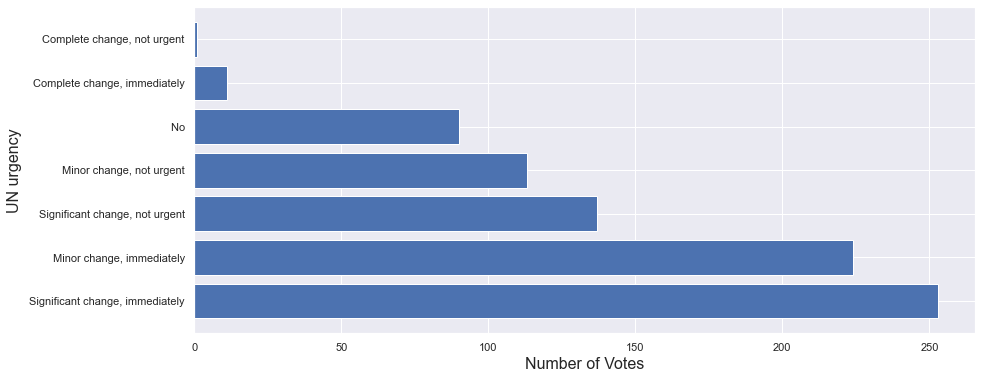

In [10]:
# One hot encoding the data 
dummies = data_pivoted.q143.str.get_dummies('|') 
#concat the one hot encoded data
data=pd.concat([data_pivoted,dummies],axis=1)


sum_count_dict = {}

#We get the sum of number of times the participant has chose a particular UN Urgency
for key in data.columns[-7:]:
    sum_count_dict[key] = data[key].sum()

#Sorting the risk factor in the descending order
sum_count_dict = dict(sorted(sum_count_dict.items(), key=lambda item: item[1], reverse=True))

questions, sum_nums = [], []
for key, value in sum_count_dict.items():
    questions.append(key[2:])
    sum_nums.append(value)
    
plt.figure(figsize=(14,6))
plt.barh(questions, sum_nums)
plt.ylabel('UN urgency', fontsize=16)
plt.xlabel('Number of Votes', fontsize=16)
plt.show()

del(data)

In [68]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

In [44]:
def create_column_change(x):
    if x is np.nan:
        return x   
    x = x.lower()
    if "complete" in x:
        return "Complete Change"
    if "minor" in x:
        return "Minor Change"
    if "significant" in x:
        return "Significant Change"
    if "no" in x:
        return "No Change"
    else:
        return "None"
data_pivoted["Change"]=data_pivoted["q143"].apply(lambda x : create_column_change(x))

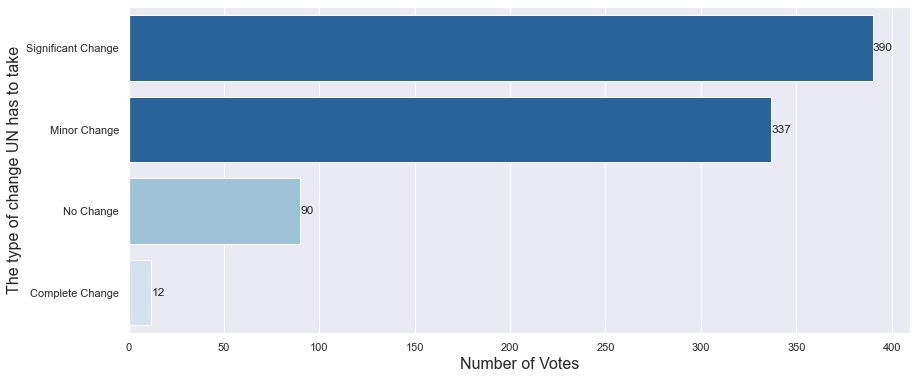

In [71]:
# One hot encoding the data 
dummies = data_pivoted.Change.str.get_dummies('|') 
#concat the one hot encoded data
data=pd.concat([data_pivoted,dummies],axis=1)
sum_count_dict = {}

#We get the sum of number of times the participant has chose a particular UN Urgency
for key in data.columns[-4:]:
    sum_count_dict[key] = data[key].sum()
    
#Sorting the risk factor in the descending order
sum_count_dict = dict(sorted(sum_count_dict.items(), key=lambda item: item[1], reverse=True))
questions, sum_nums = [], []

for key, value in sum_count_dict.items():
    questions.append(key)
    sum_nums.append(value)
plt.figure(figsize=(14,6))

ax=sns.barplot(y=questions, x=sum_nums,orient='h', palette=colors_from_values(sum_nums, "Blues"))
ax.bar_label(ax.containers[0])
plt.ylabel('The type of change UN has to take', fontsize=16)
plt.xlabel('Number of Votes', fontsize=16)
plt.show()
questions
del(data)

In [96]:
def create_column_urgency(x):
    if x is np.nan:
        return x   
    x = x.lower()
    if "not urgent" in x:
        return "Not Urgent"
    if "immediately" in x:
        return "Immediately"
    if "no" in x:
        return "No"
    else:
        return "None"
data_pivoted["Urgency"]=data_pivoted["q143"].apply(lambda x : create_column_urgency(x))

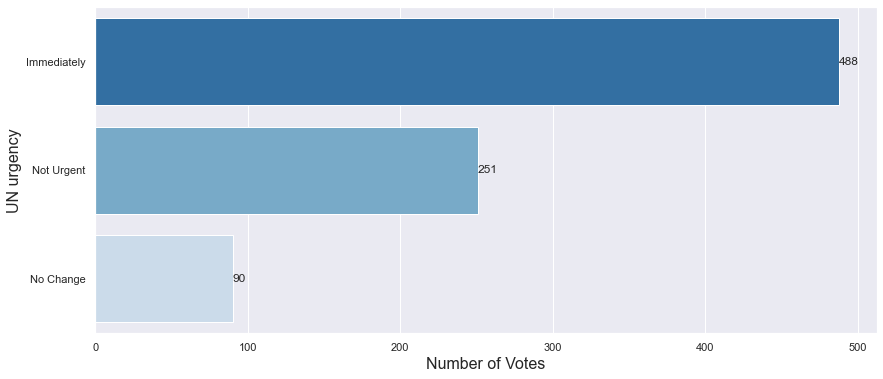

In [72]:
# One hot encoding the data 
dummies = data_pivoted.Urgency.str.get_dummies('|') 
#concat the one hot encoded data
data=pd.concat([data_pivoted,dummies],axis=1)
sum_count_dict = {}

#We get the sum of number of times the participant has chose a particular UN Urgency
for key in data.columns[-3:]:
    sum_count_dict[key] = data[key].sum()
    
#Sorting the risk factor in the descending order
sum_count_dict = dict(sorted(sum_count_dict.items(), key=lambda item: item[1], reverse=True))
questions, sum_nums = [], []

for key, value in sum_count_dict.items():
    questions.append(key)
    sum_nums.append(value)
plt.figure(figsize=(14,6))
ax=sns.barplot(y=questions, x=sum_nums,orient='h', palette=colors_from_values(sum_nums, "Blues"))
ax.bar_label(ax.containers[0])
plt.ylabel('UN urgency', fontsize=16)
plt.xlabel('Number of Votes', fontsize=16)
plt.show()
questions
del(data)

##  EDA on UN urgency

In [97]:
## Read the pivotted Data
data_pivoted=pd.read_csv("survey_data.csv")
data_pivoted = data_pivoted.loc[~data_pivoted.outcome.isna()]
data_pivoted.head()

,Country,Survey_ID,Participant_ID,outcome,q109,q111,q112,q114,q115,q117,...,q168,q170,q170specified_38,q170specified_61,q170specified_62,q180,q182,q183,q3,q7
0,Albania,Country472019-04-11,p636892769794392,Democratic space|Infrastructure & access to so...,NaN,Moderate,NaN,NaN,NaN,NaN,...,NaN,E6,NaN,NaN,NaN,NaN,NaN,NaN,Yes: Moderate,Moderate
1,Albania,Country472019-04-11,p636893140622797,Democratic space|Justice & rule of law|Politic...,NaN,High,NaN,NaN,NaN,NaN,...,NaN,E1,NaN,NaN,NaN,NaN,NaN,NaN,Yes: Moderate,High
2,Albania,Country472019-04-11,p636893695764397,Democratic space|Justice & rule of law|Social ...,Yes: Minor,Don't know,NaN,NaN,NaN,NaN,...,NaN,E4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,Country472019-04-11,p636893809832032,Justice & rule of law|Political stability|Soci...,Yes: Moderate,NaN,NaN,NaN,NaN,NaN,...,NaN,E12,NaN,NaN,NaN,NaN,NaN,NaN,Yes: Strong,Moderate
4,Albania,Country472019-04-11,p636893895810546,Democratic space|Infrastructure & access to so...,NaN,Moderate,Yes: Minor,NaN,NaN,NaN,...,NaN,E9,NaN,NaN,NaN,NaN,NaN,NaN,Yes: Moderate,Moderate


In [98]:
riskfactors = ['Political stability', 'Justice & rule of law',
       'Economic stability', 'Displacement & migration',
       'Internal security', 'Democratic space',
       'Regional & global influences', 'Environment & climate',
       'Social cohesion, equality & non-discrimination',
       'Infrastructure & access to social services',
       'Food security, agriculture & land', 'Public health',
       'Gender equality']
data_pivoted['outcome'] = data_pivoted['outcome'].str.split('|')
data_pivoted['outcome'] = data_pivoted['outcome'].apply(lambda x: riskfactors if "All of the above" in x else x)
data_pivoted = data_pivoted.explode('outcome', ignore_index=True)

In [99]:
data_pivoted["q143"]=data_pivoted["q143"].fillna("None")
data_pivoted["Change"]=data_pivoted["q143"].apply(lambda x : create_column_change(x))
data_pivoted["Urgency"]=data_pivoted["q143"].apply(lambda x : create_column_urgency(x))

In [100]:
Un_change_map={'Minor Change':1,'Significant Change':3,'No':0, 'Complete Change':2,'None':0}
data_pivoted["Change"]=data_pivoted["Change"].apply(lambda x: Un_change_map[x])

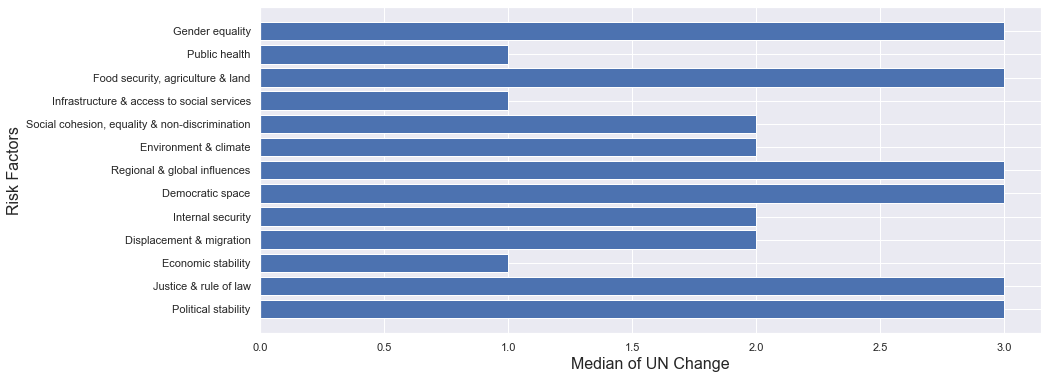

In [115]:
plt.figure(figsize=(14,6))
x=pd.DataFrame(data_pivoted.loc[~data_pivoted.q143.isin(["No","None"])].groupby(["outcome"]).median().reset_index()).Change
plt.barh(riskfactors,x)
plt.ylabel('Risk Factors', fontsize=16)
plt.xlabel('Median of UN Change', fontsize=16)
plt.show()

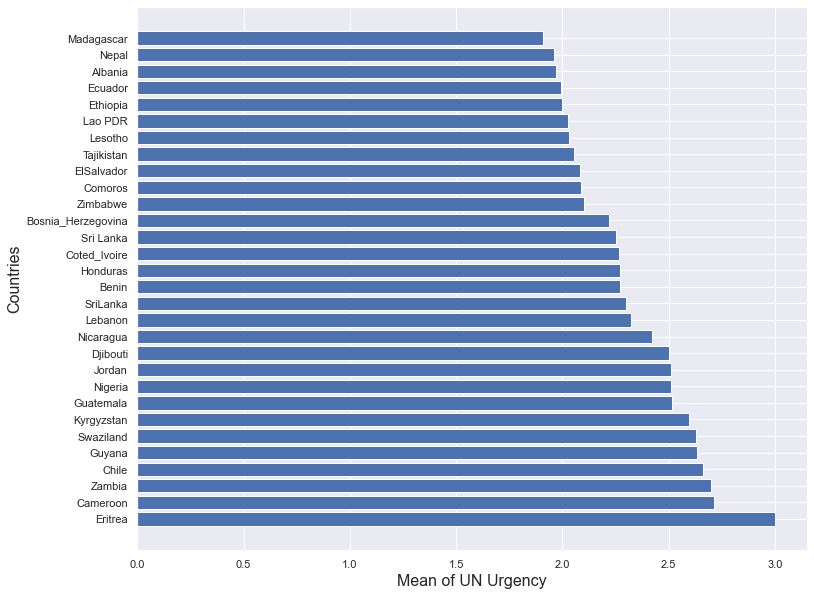

In [102]:
plt.figure(figsize=(12,10))
x=pd.DataFrame(data_pivoted.loc[~data_pivoted.q143.isin(["No","None"])].groupby(["Country"]).mean().reset_index().sort_values(by="Change",ascending=False)[:30])
plt.barh(x.Country,x.Change)
plt.ylabel('Countries', fontsize=16)
plt.xlabel('Mean of UN Urgency', fontsize=16)
plt.show()

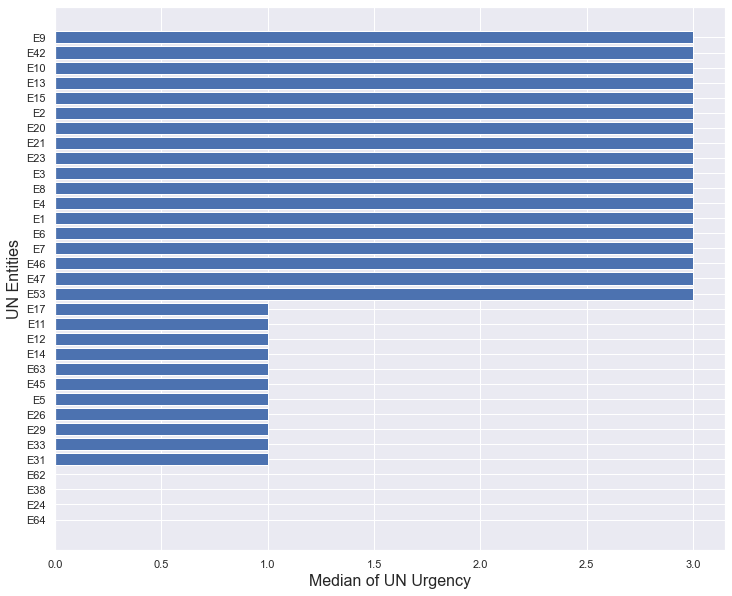

In [106]:
plt.figure(figsize=(12,10))
x=pd.DataFrame(data_pivoted.loc[~data_pivoted.q143.isin(["No","None"])].groupby(["q170"]).median().reset_index().sort_values(by="Change"))
plt.barh(x.q170,x.Change)
plt.ylabel('UN Entities', fontsize=16)
plt.xlabel('Median of UN Urgency', fontsize=16)
plt.show()

In [107]:
data_pivoted.Urgency.unique()

array(['Not Urgent', 'No', 'Immediately'], dtype=object)

In [108]:
Un_Urgency_map={'Not Urgent':1,'Immediately':2,'No':0,'None':0}
data_pivoted["Urgency"]=data_pivoted["Urgency"].apply(lambda x: Un_Urgency_map[x])

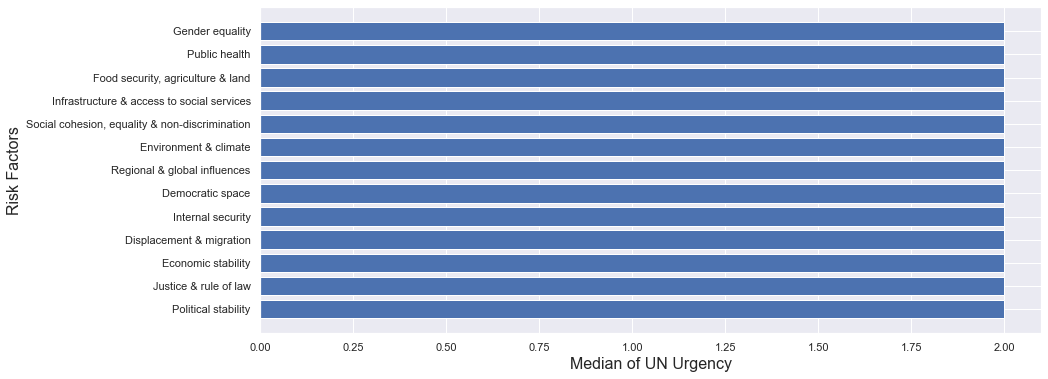

In [117]:
plt.figure(figsize=(14,6))
x=pd.DataFrame(data_pivoted.loc[~data_pivoted.q143.isin(["No","None"])].groupby(["outcome"]).median().reset_index()).Urgency
plt.barh(riskfactors,x)
plt.ylabel('Risk Factors', fontsize=16)
plt.xlabel('Median of UN Urgency', fontsize=16)
plt.show()

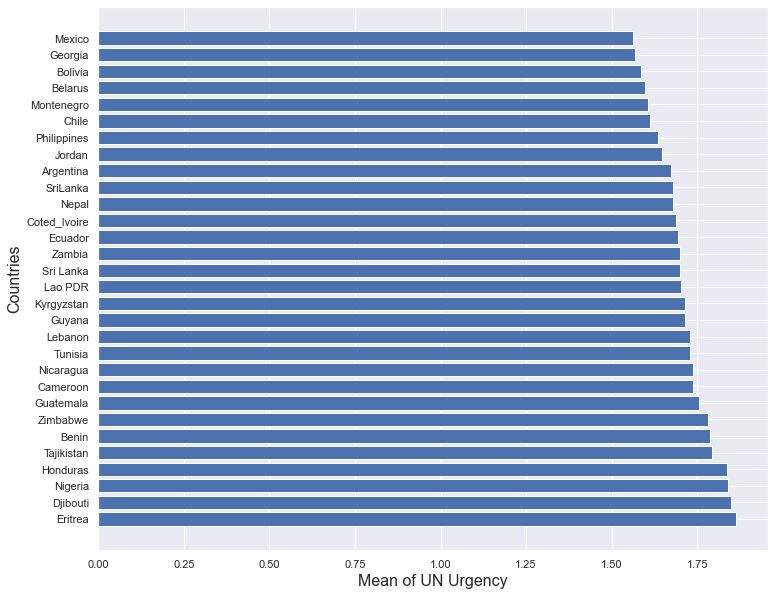

In [112]:
plt.figure(figsize=(12,10))
x=pd.DataFrame(data_pivoted.loc[~data_pivoted.q143.isin(["No","None"])].groupby(["Country"]).mean().reset_index().sort_values(by="Urgency",ascending=False)[:30])
plt.barh(x.Country,x.Urgency)
plt.ylabel('Countries', fontsize=16)
plt.xlabel('Mean of UN Urgency', fontsize=16)
plt.show()

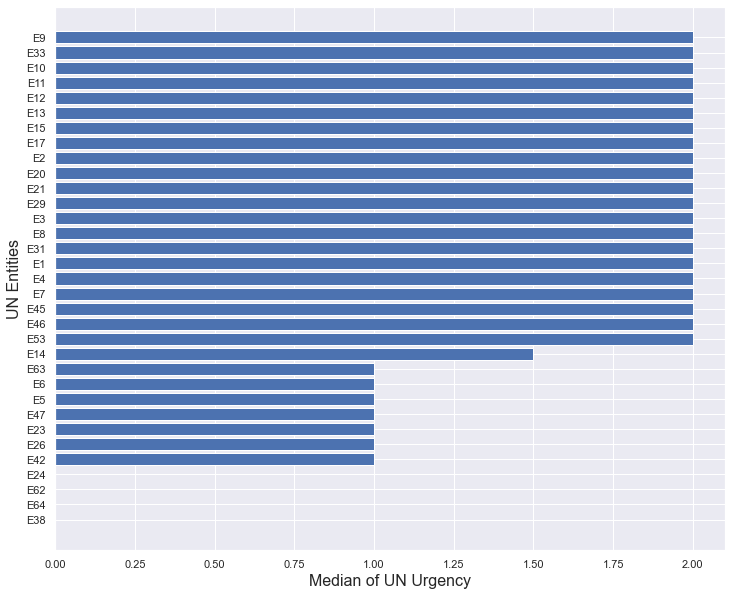

In [113]:
plt.figure(figsize=(12,10))
x=pd.DataFrame(data_pivoted.loc[~data_pivoted.q143.isin(["No","None"])].groupby(["q170"]).median().reset_index().sort_values(by="Urgency"))
plt.barh(x.q170,x.Urgency)
plt.ylabel('UN Entities', fontsize=16)
plt.xlabel('Median of UN Urgency', fontsize=16)
plt.show()

# Roll up of the scores 

In [174]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [175]:
data=pd.read_csv("survey_data.csv")
data.head()

,Country,Survey_ID,Participant_ID,outcome,q109,q111,q112,q114,q115,q117,q118,q120,q121,q123,q124,q126,q127,q129,q130,q132,q133,q135,q136,q138,q139,q141,q143,q145,q147,q149,q152,q154,q156,q158,q160,q162,q164,q166,q168,q170,q170specified_38,q170specified_61,q170specified_62,q180,q182,q183,q3,q7
0,Albania,Country472019-04-11,p636892769794392,Democratic space|Infrastructure & access to so...,NaN,Moderate,NaN,NaN,NaN,NaN,Yes: Moderate,NaN,NaN,NaN,Yes: Minor,Moderate,NaN,NaN,NaN,Moderate,NaN,NaN,NaN,NaN,Yes: Moderate,NaN,"2: Minor change, not urgent",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E6,NaN,NaN,NaN,NaN,NaN,NaN,Yes: Moderate,Moderate
1,Albania,Country472019-04-11,p636893140622797,Democratic space|Justice & rule of law|Politic...,NaN,High,NaN,NaN,NaN,NaN,Yes: Minor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Moderate,NaN,NaN,NaN,NaN,Yes: Moderate,NaN,"2: Minor change, not urgent",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E1,NaN,NaN,NaN,NaN,NaN,NaN,Yes: Moderate,High
2,Albania,Country472019-04-11,p636893695764397,Democratic space|Justice & rule of law|Social ...,Yes: Minor,Don't know,NaN,NaN,NaN,NaN,Yes: Minor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Don't know,NaN,NaN,NaN,NaN,Yes: Minor,Don't know,"4: Significant change, not urgent",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,Country472019-04-11,p636893809832032,Justice & rule of law|Political stability|Soci...,Yes: Moderate,NaN,NaN,NaN,NaN,NaN,Yes: Moderate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Moderate,NaN,NaN,NaN,NaN,NaN,Moderate,"2: Minor change, not urgent",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E12,NaN,NaN,NaN,NaN,NaN,NaN,Yes: Strong,Moderate
4,Albania,Country472019-04-11,p636893895810546,Democratic space|Infrastructure & access to so...,NaN,Moderate,Yes: Minor,NaN,NaN,NaN,Yes: Moderate,NaN,NaN,NaN,Yes: Minor,Moderate,NaN,NaN,NaN,Moderate,NaN,NaN,NaN,Moderate,Yes: Moderate,NaN,"4: Significant change, not urgent",Low,Low,NaN,NaN,NaN,NaN,Moderate,NaN,Low,NaN,Low,NaN,E9,NaN,NaN,NaN,NaN,NaN,NaN,Yes: Moderate,Moderate


In [176]:
cols = list(data.columns[4:])

def rep_map_scores(x):
    
    ### Possible answers to standardize
    # identity and demographics - drop column
    # national/UN coping capacity - very high, high, moderate, low, none, don't know
    # risk increase potential - yes: very strong, yes: strong, yes: moderate, yes: minor, no, don't know
    
    if x is np.nan:
        return x
    
    x = x.lower()
    
    if ('very' in x) and ('high' in x or 'strong' in x):
        return 5
    
    if ('high' in x or 'strong' in x):
        return 4
    
    if ('moderate' in x):
        return 3
    
    if ('low' in x or 'minor' in x):
        return 2
    
    if ("no" in x):
        return 1
    
    if ("none" in x or "don't" in x):
        return 0

def rep_coping_scores(x):
    
    ### Possible answers to standardize
    # identity and demographics - drop column
    # national/UN coping capacity - very high, high, moderate, low, none, don't know
    # risk increase potential - yes: very strong, yes: strong, yes: moderate, yes: minor, no, don't know
    
    if x is np.nan:
        return x
    
    x = x.lower()
    
    if ('very' in x) and ('high' in x or 'strong' in x):
        return 1
    
    if ('high' in x or 'strong' in x):
        return 2
    
    if ('moderate' in x):
        return 3
    
    if ('low' in x or 'minor' in x):
        return 4
    
    if ("none" in x or "don't" in x):
        return 0   

for c in cols:
    # drop q170
    if 'q170' in c:
        del data[c]
        continue
    
    if c in ['q133','q136',"q109","q121","q118","q112","q3","q115","q139","q130","q127","q124","q180"]:
        data[c] = data[c].apply(rep_map_scores)
    elif 'q143' not in c:
        data[c] = data[c].apply(rep_coping_scores)
        
    
data.drop(["q143"],axis=1,inplace=True)


In [177]:
data=data.rename(columns = {'q133':'Economic Stability',
                            'q136':'Displace & Migration',
                            "q109":"Social Cohesion",
                            "q121":"Internal Security",
                            "q118":"Justice Rule",
                            "q112":"Regional and Global influences",
                            "q3":"Political Stability",
                            "q115":"Public Health",
                            "q139":"Democratic Space",
                            "q130":"Enviroment & Climate",
                            "q127":"Food security, agriculture & land",
                            "q124":"Infrastructure & Access","q180":"Gender inequality"})

##Combining the scores based on mapping given by UN for coping capacity
data["Economic Stability"]=data["Economic Stability"]+data["q135"]+data["q152"]
data["Displace & Migration"]=data["Displace & Migration"]+data["q138"]+data["q149"]
data["Social Cohesion"]=data["Social Cohesion"]+data["q111"]+data["q168"]
data["Internal Security"]=data["Internal Security"]+data["q123"]+data["q160"]
data["Justice Rule"]=data["Justice Rule"]+data["q120"]+data["q162"]
data["Regional and Global influences"]=data["Regional and Global influences"]+data["q114"]+data["q166"]
data["Political Stability"]=data["Political Stability"]+data["q7"]+data["q145"]
data["Public Health"]=data["Public Health"]+data["q117"]+data["q164"]
data["Democratic Space"]=data["Democratic Space"]+data["q141"]+data["q147"]
data["Enviroment & Climate"]=data["Enviroment & Climate"]+data["q132"]+data["q154"]
data["Food security, agriculture & land"]=data["Food security, agriculture & land"]+data["q129"]+data["q156"]
data["Infrastructure & Access"]=data["Infrastructure & Access"]+data["q126"]+data["q158"]
data["Gender inequality"]=data["Gender inequality"]+data["q182"]+data["q183"]

In [178]:
data.drop(['q111', 'q114','q117','q120','q123','q126','q129','q132','q135',
           'q138','q141','q145', 'q147', 'q149', 'q152', 'q154', 'q156', 'q158', 'q160', 'q162',
       'q164', 'q166', 'q168', 'q7','q182','q183'],axis=1,inplace=True)

In [179]:
data.head()

,Country,Survey_ID,Participant_ID,outcome,Social Cohesion,Regional and Global influences,Public Health,Justice Rule,Internal Security,Infrastructure & Access,"Food security, agriculture & land",Enviroment & Climate,Economic Stability,Displace & Migration,Democratic Space,Gender inequality,Political Stability
0,Albania,Country472019-04-11,p636892769794392,Democratic space|Infrastructure & access to so...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,Country472019-04-11,p636893140622797,Democratic space|Justice & rule of law|Politic...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,Country472019-04-11,p636893695764397,Democratic space|Justice & rule of law|Social ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,Country472019-04-11,p636893809832032,Justice & rule of law|Political stability|Soci...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Albania,Country472019-04-11,p636893895810546,Democratic space|Infrastructure & access to so...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0


In [180]:
data_mean_sum_per_country=pd.DataFrame(data.fillna(0).groupby(['Country','Survey_ID']).mean()).reset_index().groupby(["Country"]).mean().reset_index()

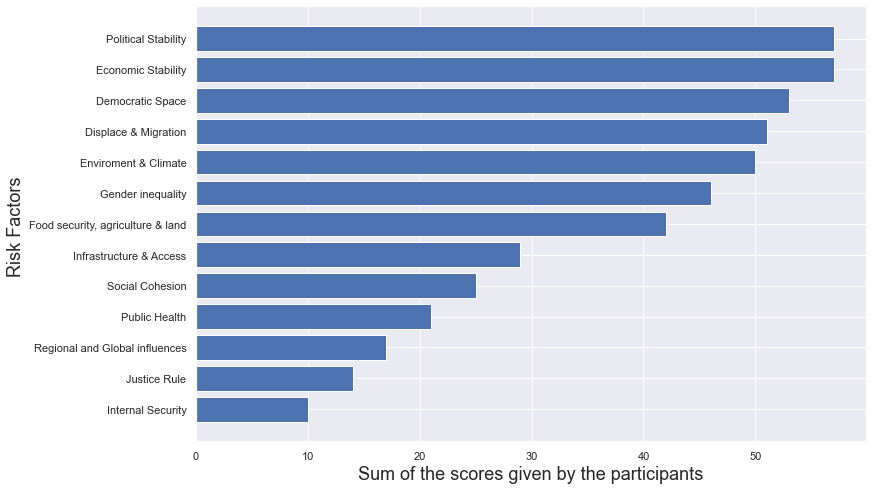

In [181]:
top_five_risks_per_country={}
for i in range(len(data_mean_sum_per_country)):
    top_five_risks_per_country[data_mean_sum_per_country.iloc[i][0]]=list(data_mean_sum_per_country.iloc[i][1:].sort_values()[5:].index)
    
Count_of_risks_priority={}
for x in top_five_risks_per_country.values():
    for y in x:
        if y in Count_of_risks_priority:
            Count_of_risks_priority[y]+=1
        else:
            Count_of_risks_priority[y]=1
            
Count_of_risks_priority=dict(sorted(Count_of_risks_priority.items(), key=lambda item: item[1]))       
names = list(Count_of_risks_priority.keys())
values = list(Count_of_risks_priority.values())

plt.subplots(figsize = (12,8))
plt.barh(range(len(Count_of_risks_priority)), values, tick_label=names)
plt.xlabel("Sum of the scores given by the participants",fontsize=18)
plt.ylabel("Risk Factors ",fontsize=18)
plt.show()

In [182]:
data1=data.replace(0.0,np.nan)
data_country_vote=pd.DataFrame(data1.groupby(['Country','Survey_ID']).count()).reset_index()
data_vote_sum_per_country=pd.DataFrame(data_country_vote.groupby(["Country"]).sum().reset_index())
data_vote_sum_per_country.drop(["Participant_ID","outcome"],axis=1,inplace=True)

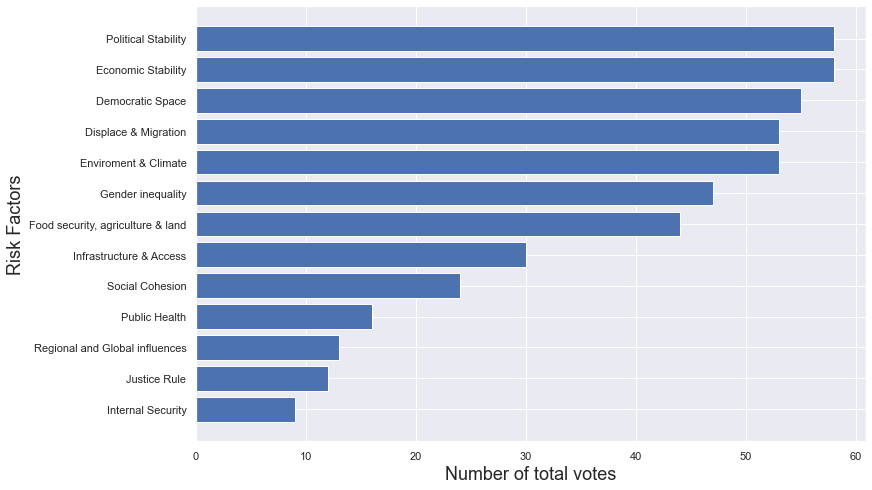

In [183]:
top_five_risks_per_country={}
for i in range(len(data_vote_sum_per_country)):
    top_five_risks_per_country[data_vote_sum_per_country.iloc[i][0]]=list(data_vote_sum_per_country.iloc[i][1:].sort_values()[5:].index)
    
Count_of_risks_priority={}
for x in top_five_risks_per_country.values():
    for y in x:
        if y in Count_of_risks_priority:
            Count_of_risks_priority[y]+=1
        else:
            Count_of_risks_priority[y]=1

Count_of_risks_priority=dict(sorted(Count_of_risks_priority.items(), key=lambda item: item[1]))            
names = list(Count_of_risks_priority.keys())
values = list(Count_of_risks_priority.values())

plt.subplots(figsize = (12,8))
plt.barh(range(len(Count_of_risks_priority)), values, tick_label=names)
plt.ylabel("Risk Factors",fontsize=18)
plt.xlabel("Number of total votes",fontsize=18)
plt.show()